In [46]:
from itertools import permutations
import cv2, glob
import imutils, math
from tqdm import tqdm
import pandas as pd
example = '../input/train_data/2.png'

In [36]:
def get_colors():
    set_col = set()
    for l1, l2, l3 in permutations(range(256), 3):
        set_col.add((l1, l2, l3))
    return set_col

In [40]:
import re
test_path = glob.glob('../input/test_data/*')
test_path_sorted = [s[1] for s in sorted(
    [(int(re.findall('\d+',v)[0]), v
     ) for v in test_path], key=lambda x: x[0])]
test_path_sorted[:2]

['../input/test_data/1.png', '../input/test_data/2.png']

In [41]:
def count_diag(length_list):
    if len(length_list) == 1 and length_list[0] == 0:
        return 0
    dist_list = []
    dist_set = set()
    for l1, l2 in permutations(length_list, 2):
        if (l1, l2) not in dist_set and (l2, l1) not in dist_set:
            dist_list.append(l1 == l2)
            dist_set.add((l1, l2))
    return sum(dist_list) 

In [38]:
count_squards = []
# Load image, grayscale, blur, Otsu's threshold
for file in tqdm(test_path_sorted):
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove small noise with contour area filtering
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    cnts = imutils.grab_contours(cnts)
    
    
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 150:
            cv2.drawContours(thresh, [c], -1, 0, -1)

    # Find corners and draw onto image
    corners = cv2.goodFeaturesToTrack(thresh,150,0.5,5)
    i = 155
    length_list = []
    dist_list = []
    try:
        for corner in corners:
            x,y = corner.ravel()
    #         for col in get_colors():
            cv2.circle(image,(int(x),int(y)),3,(36,255,255),-1)
            dist = math.sqrt( ((int(x)-int(y))**2)+((int(x)-int(y))**2) )
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.5
            fontColor = (255,0,0)
            lineType = 1
    #         cv2.putText(image,str(dist),(i,i),font, fontScale, fontColor, lineType)
            length_list.append(dist)
            i -= 10
    except:
        length_list.append(0)
            

    # The number of rectangles is corners / 4
#     print('Squares: {}'.format(len(corners)/4))

#     cv2.imshow('image', image)
    
#     cv2.waitKey()
    count_squards.append(count_diag(length_list))

NameError: name 'test_path_sorted' is not defined

In [47]:
len(count_squards)
df_ans = pd.read_csv('../input/sample_submission_squard.csv')
df_ans['label'] = count_squards
df_ans.to_csv('../input/sample_submission_squard.csv', index=False)

### 2 approach

In [68]:
import numpy as np

In [166]:
image=cv2.imread('../input/train_data/14.png')
cv2.imshow('input image',image)
# cv2.waitKey()

In [167]:
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
edged=cv2.Canny(gray,30,200)
cv2.imshow('canny edges',edged)
# cv2.waitKey()

In [168]:
#use a copy of your image, e.g. - edged.copy(), since finding contours alter the image
#we have to add _, before the contours as an empty argument due to upgrade of the OpenCV version
contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
cv2.imshow('canny edges after contouring', edged)
# cv2.waitKey()


In [169]:
# print(contours)
print('Numbers of contours found=' + str(len(contours)))

Numbers of contours found=32


In [220]:
#use -1 as the 3rd parameter to draw all the contours
cv2.drawContours(image,contours,-1,(0,255,0),3)
cv2.imshow('contours',image)
cv2.waitKey()
cv2.destroyAllWindows()

In [221]:
orig_image=image.copy()
cv2.imshow('original image',orig_image)
# cv2.waitKey()

In [222]:
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, thresh=cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
contours, hierarchy=cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

In [223]:
for c in contours:
    x,y,w,h=cv2.boundingRect(c)
    cv2.rectangle(orig_image,(x,y),(x+w,y+h),(0,0,255),2)
    cv2.imshow('Bounding rect',orig_image)
# cv2.waitKey()

In [224]:
#calculate accuracy as a percent of contour perimeter
accuracy=0.03*cv2.arcLength(c,True)
approx=cv2.approxPolyDP(c,accuracy,True)
cv2.drawContours(image,[approx],0,(0,255,0),2)
cv2.imshow('Approx polyDP', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [225]:
n=len(contours)-1
contours=sorted(contours,key=cv2.contourArea,reverse=False)[:n]

In [226]:
hull=cv2.convexHull(c)
cv2.drawContours(image,[hull],0,(0,255,0),2)
cv2.imshow('convex hull',image)
cv2.waitKey()
cv2.destroyAllWindows()

In [227]:
target=cv2.imread('../input/train_data/0.png')
template=image
gray=cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)
ret,thresh1=cv2.threshold(template,127,255,0)
ret,thresh2=cv2.threshold(gray,127,255,0)

In [230]:
sorted_contours=sorted(contours, key=cv2.contourArea, reverse=True)
#we extract the second largest contour which will be our template contour
tempelate_contour=contours[2]
#extract the contours from the second target image
contours,hierarchy=cv2.findContours(thresh2,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for c in contours:
    #iterate through each contour in the target image and use cv2.matchShape to compare the contour shape
    match=cv2.matchShapes(tempelate_contour,c,1,0.0)
    print("match")
    #if match value is less than 0.15
    print(match)
    if match<0.15:
        closest_contour=c
    else:
        closest_contour=[]
print(closest_contour)
cv2.drawContours(target,[closest_contour],-1,(0,255,0),3)
cv2.imshow('output',target)
cv2.waitKey()
cv2.destroyAllWindows()


match
0.0032385010771178724
[[[  0   0]]

 [[  0 319]]

 [[319 319]]

 [[319   0]]]


In [241]:
image=cv2.imread('../input/train_data/1.png')
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.imshow('identifying shapes',image)
cv2.waitKey(0)

ret, thresh=cv2.threshold(gray,127,255,1)

In [242]:
contours, hierarchy=cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

In [243]:
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    if len(approx)==3:
        shape_name="Triangle"
        cv2.drawContours(image,[cnt],0,(0,255,0),-1)
        M=cv2.moments(cnt)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        cv2.putText(image,shape_name,(cx-50,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx)==4:
        x,y,w,h=cv2.boundingRect(cnt)
        M=cv2.moments(cnt)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
    #cv2.boundingRect return the left width and height in pixels, starting from the top
            #left corner, for square it would be roughly same     
        if abs(w-h) <= 3:
            shape_name="square"
            #find contour center to place text at center
            cv2.drawContours(image,[cnt],0,(0,125,255),-1)
            cv2.putText(image,shape_name,(cx-50,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)         
        else:
            shape_name="Reactangle"
            #find contour center to place text at center
            cv2.drawContours(image,[cnt],0,(0,0,255),-1)
            M=cv2.moments(cnt)
            cx=int(M['m10']/M['m00'])
            cy=int(M['m01']/M['m00'])
            cv2.putText(image,shape_name,(cx-50,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx)==10:
        shape_name='star'
        cv2.drawContours(image,[cnt],0,(255,255,0),-1)
        M=cv2.moments(cnt)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        cv2.putText(image,shape_name,(cx-50,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
    elif len(approx)>=15:
        shape_name='circle'
        cv2.drawContours(image,[cnt],0,(0,255,255),-1)
        M=cv2.moments(cnt)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        cv2.putText(image,shape_name,(cx-50,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1)
cv2.imshow('identifying shapes', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [239]:
contours = contours_

In [278]:
import numpy as np
import cv2

img = cv2.imread('../input/train_data/3.png')
imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret , thrash = cv2.threshold(imgGry, 240 , 255, cv2.CHAIN_APPROX_NONE)
contours , hierarchy = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)


count_square = 0
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
    cv2.drawContours(img, [approx], 0, (0, 0, 0), 5)
    x = approx.ravel()[0]
    y = approx.ravel()[1] - 5
    if len(approx) == 3:
        cv2.putText( img, "Triangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0) )
    elif len(approx) == 4 :
        x, y , w, h = cv2.boundingRect(approx)
        aspectRatio = float(w)/h
        print(aspectRatio)
        if aspectRatio >= 0.95 and aspectRatio < 1.05:
            cv2.putText(img, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
            count_square += 1

        else:
            cv2.putText(img, "rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

    elif len(approx) == 5 :
        cv2.putText(img, "pentagon", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
    elif len(approx) == 10 :
        cv2.putText(img, "star", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
    else:
        cv2.putText(img, "circle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

cv2.imshow('shapes', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
count_square

1.0
1.0
1.0135135135135136
1.0
1.0
1.0
1.0
1.0
1.0
0.9861111111111112
1.0
1.3170731707317074
1.2972972972972974
1.0
1.0
0.37623762376237624


13

### 3 approach 

In [393]:
import PIL
from PIL import Image
from io import BytesIO
from PIL import ImageFilter
from PIL import ImageEnhance
from IPython.display import display
import numpy as np


In [433]:
img = Image.open(example)
 
# get the mode of the image
img.mode 
# it returns 'rgb'
 
# create a grayscale image
grayimg = img.convert('L')
grayimg.mode

'L'

In [434]:
# get the pixel of the top left corner of the RGB image
img.getpixel((0,0))
# we get (44, 110, 160) since it is an RGB we expected a tuple of 3-D taking values from 0-255
 
# get the pixel of the top left corner of the grayscale image
grayimg.getpixel((0,0))
# it returns 95 , as we expected we got only one element within the range of 0-255


255

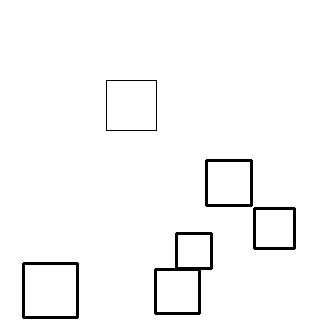

In [437]:
def binarize(image_to_transform, threshold):
    # now, lets convert that image to a single greyscale image using convert()
    output_image=image_to_transform.convert("L")
    for x in range(output_image.width):
        for y in range(output_image.height):
            # for the given pixel at w,h, lets check its value against the threshold
            if output_image.getpixel((x,y))< threshold: #note that the first parameter is actually a tuple object
                # lets set this to zero
#                 print('1', (x,y))
                output_image.putpixel( (x,y), 0 )
            else:
#                 print('2', (x,y))
#                 otherwise lets set this to 255
                output_image.putpixel( (x,y), 255 )
    #now we just return the new image
    return output_image
 
binarize(img, 200)

### 4 approach

In [3]:
import cv2


In [44]:
count_square_list = []
for file in tqdm(test_path_sorted):
    img = cv2.imread(file, 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gauss = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)
    ret,thresh = cv2.threshold(gauss,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    rev=255-thresh

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST ,cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    min_rect_len = 15
    max_rect_len = 20

    count_square = 0
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if h>min_rect_len and w>min_rect_len:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)
            count_square += 1
    count_square_list.append(int(count_square / 4))
    # cv2.imwrite(example, img)
    # cv2.imshow('shapes', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:09<00:00, 664.85it/s]


In [48]:
df_ans['label'] = count_square_list
df_ans.to_csv('../input/sample_submission_squard_2.csv', index=False)